In [ ]:
# !pip install torch==2.0.1+cu117 torchvision==0.15.2+cu117 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu117
#pip install torchmetrics
import torch
from torch import nn
import os
from os import path
import torchvision
import torchvision.transforms as T
from typing import Sequence
from torchvision.transforms import functional as F
import numbers
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torchmetrics as TM
from tqdm import tqdm
from typing import List, Tuple
from pathlib import Path

# Convert a pytorch tensor into a PIL image
t2img = T.ToPILImage()
# Convert a PIL image into a pytorch tensor
img2t = T.ToTensor()
working_dir = Path("data/")
models_dir = Path("models/")

# Validation: Check if CUDA is available
print(f"CUDA: {torch.cuda.is_available()}")

CUDA: True


In [ ]:
# Create a dataset wrapper that allows us to perform custom image augmentations
# on both the target and label (segmentation mask) images.
#
# These custom image augmentations are needed since we want to perform
# transforms such as:
# 1. Random horizontal flip
# 2. Image resize
#
# and these operations need to be applied consistently to both the input
# image as well as the segmentation mask.
class OxfordIIITPetsAugmented(torchvision.datasets.OxfordIIITPet):
    def __init__(
        self,
        root: str,
        split: str,
        target_types="segmentation",
        download=False,
        pre_transform=None,
        post_transform=None,
        pre_target_transform=None,
        post_target_transform=None,
        common_transform=None,
    ):
        super().__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=pre_transform,
            target_transform=pre_target_transform,
        )
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)

        # Common transforms are performed on both the input and the labels
        # by creating a 4 channel image and running the transform on both.
        # Then the segmentation mask (4th channel) is separated out.
        if self.common_transform is not None:
            both = torch.cat([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 3, dim=0)

        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)

        return (input, target)

In [ ]:
# Simple torchvision compatible transform to send an input tensor
# to a pre-specified device.
class ToDevice(torch.nn.Module):
    """
    Sends the input object to the device specified in the
    object's constructor by calling .to(device) on the object.
    """
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(device={device})"

In [ ]:
def save_model_checkpoint(model: nn.Module, path: str) -> None:
    print(type(model))
    torch.save(model.state_dict(), path)

# Load model from saved checkpoint
def load_model_from_checkpoint(model: nn.Module, path: str):
    return model.load_state_dict(
        torch.load(
            path,
            map_location=get_device(),
        )
    )

def get_model_parameters(m):
    total_params = sum(
        param.numel() for param in m.parameters()
    )
    return total_params

def print_model_parameters(m):
    num_model_parameters = get_model_parameters(m)
    print(f"The Model has {num_model_parameters/1e6:.2f}M parameters")


def get_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# Send the Tensor or Model (input argument x) to the right device
# for this notebook. i.e. if GPU is enabled, then send to GPU/CUDA
# otherwise send to CPU.
def to_device(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x.cpu()

def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()

# Create a tensor for a segmentation trimap.
# Input: Float tensor with values in [0.0 .. 1.0]
# Output: Long tensor with values in {0, 1, 2}
def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

# Convert a float trimap ({1, 2, 3} / 255.0) into a float tensor with
# pixel values in the range 0.0 to 1.0 so that the border pixels
# can be properly displayed.
def trimap2f(trimap):
    return (img2t(trimap) * 255.0 - 1) / 2

def args_to_dict(**kwargs):
    return kwargs

# Data

In [ ]:
pets_train_orig = torchvision.datasets.OxfordIIITPet(root=working_dir / 'OxfordPets' / 'train', split="trainval", target_types="segmentation", download=True)
pets_test_orig = torchvision.datasets.OxfordIIITPet(root=working_dir / 'OxfordPets' / 'test', split="test", target_types="segmentation", download=True)

In [ ]:
pets_train_orig, pets_test_orig

(Dataset OxfordIIITPet
     Number of datapoints: 3680
     Root location: data/OxfordPets/train,
 Dataset OxfordIIITPet
     Number of datapoints: 3669
     Root location: data/OxfordPets/test)

In [ ]:
(train_pets_input, train_pets_target) = pets_train_orig[0]

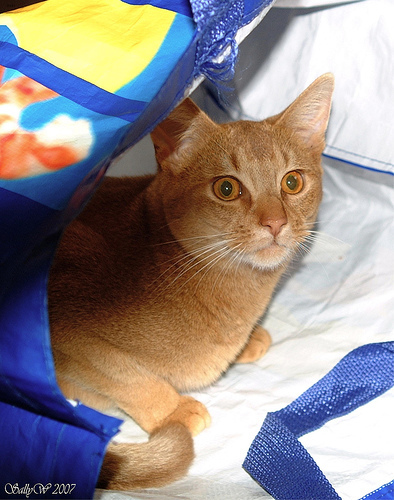

In [ ]:
train_pets_input

In [ ]:
from enum import IntEnum
class TrimapClasses(IntEnum):
    PET = 0
    BACKGROUND = 1
    BORDER = 2

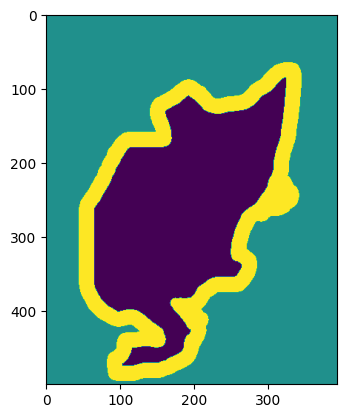

In [ ]:
plt.imshow(train_pets_target)

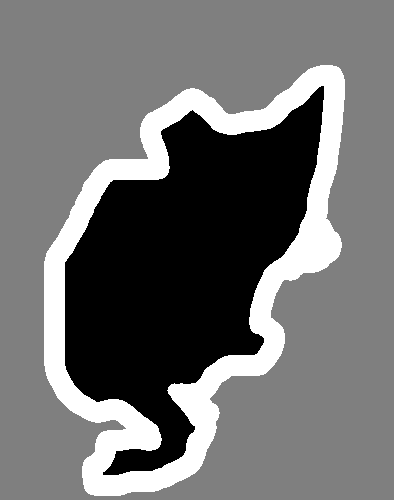

In [ ]:
t2img(trimap2f(train_pets_target))

In [ ]:
transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=T.Compose([
        ToDevice(get_device()),
        T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST),
        # Random Horizontal Flip as data augmentation.
        T.RandomHorizontalFlip(p=0.5),
    ]),
    post_transform=T.Compose([
        # Color Jitter as data augmentation.
        T.ColorJitter(contrast=0.3),
    ]),
    post_target_transform=T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)

# Create the train and test instances of the data loader for the
# Oxford IIIT Pets dataset with random augmentations applied.
# The images are resized to 128x128 squares, so the aspect ratio
# will be chaged. We use the nearest neighbour resizing algorithm
# to avoid disturbing the pixel values in the provided segmentation
# mask.
pets_train = OxfordIIITPetsAugmented(
    root=working_dir / 'OxfordPets' / 'train',
    split="trainval",
    download=False,
    target_types="segmentation",
    **transform_dict,
)
pets_test = OxfordIIITPetsAugmented(
    root=working_dir / 'OxfordPets' / 'test',
    split="test",
    download=False,
    target_types="segmentation",
    **transform_dict,
)

pets_train, pets_val = torch.utils.data.random_split(pets_train, [3659, 21])

pets_train_loader = torch.utils.data.DataLoader(
    pets_train,
    batch_size=64,
    shuffle=True,
)
pets_test_loader = torch.utils.data.DataLoader(
    pets_test,
    batch_size=21,
    shuffle=True,
)
pets_val_loader = torch.utils.data.DataLoader(
    pets_val,
    batch_size=21,
    shuffle=True,
)

(train_pets_inputs, train_pets_targets) = next(iter(pets_train_loader))
(test_pets_inputs, test_pets_targets) = next(iter(pets_test_loader))
(val_pets_inputs, val_pets_targets) = next(iter(pets_val_loader))
train_pets_inputs.shape, train_pets_targets.shape, test_pets_inputs.shape, test_pets_targets.shape, val_pets_inputs.shape, val_pets_targets.shape,

(torch.Size([64, 3, 128, 128]),
 torch.Size([64, 1, 128, 128]),
 torch.Size([21, 3, 128, 128]),
 torch.Size([21, 1, 128, 128]),
 torch.Size([21, 3, 128, 128]),
 torch.Size([21, 1, 128, 128]))

In [ ]:
# Let's inspect some of the images.
pets_input_grid = torchvision.utils.make_grid(train_pets_inputs, nrow=8)
t2img(pets_input_grid)

Output hidden; open in https://colab.research.google.com to view.

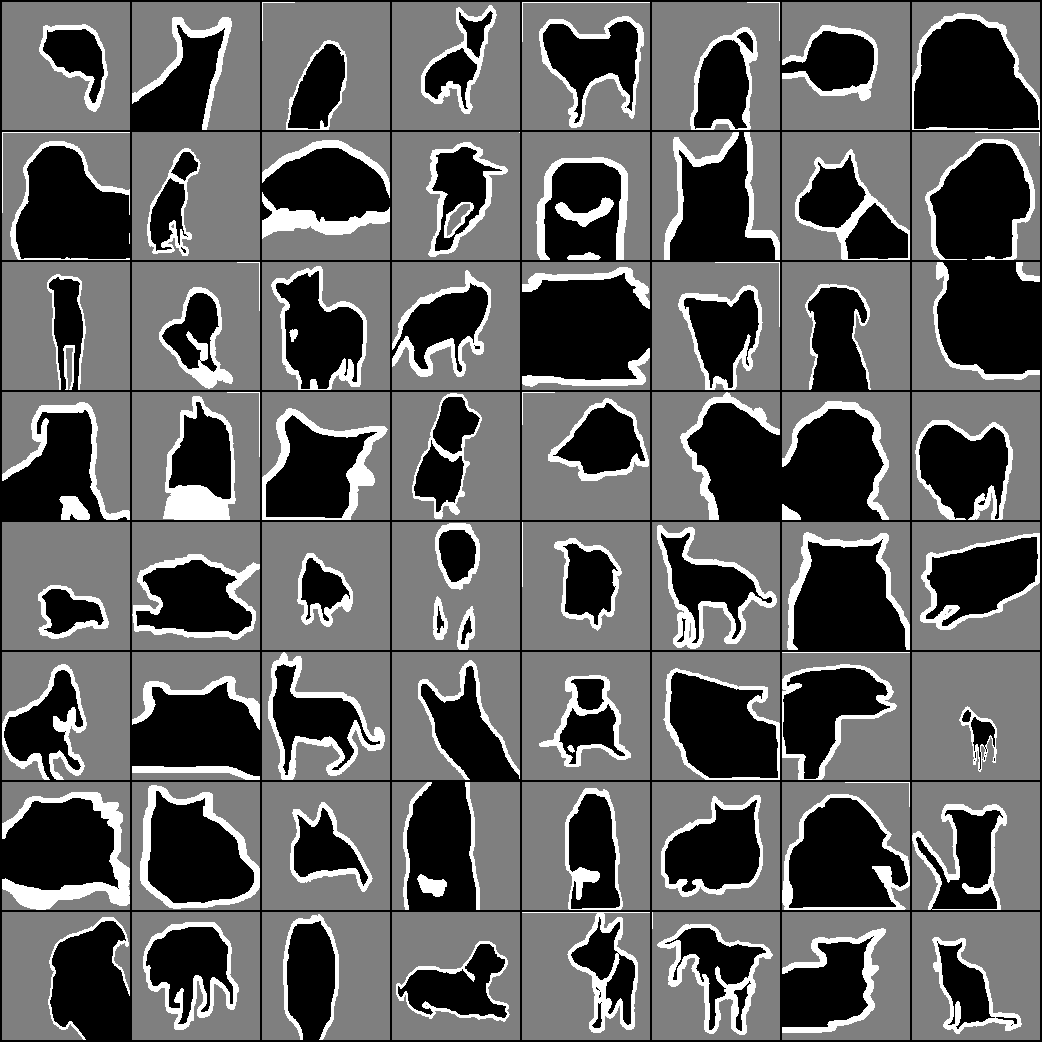

In [ ]:
# Let's inspect the segmentation masks corresponding to the images above.
# When plotting the segmentation mask, we want to convert the tensor
# into a float tensor with values in the range [0.0 to 1.0]. However, the
# mask tensor has the values (0, 1, 2), so we divide by 2.0 to normalize.
pets_targets_grid = torchvision.utils.make_grid(train_pets_targets / 2.0, nrow=8)
t2img(pets_targets_grid)

In [ ]:
#                  N  C  H
# The printed row is the W dimension.
train_pets_targets[3][0][4]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

# Model

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )


    def forward(self, x):
        out = self.double_conv(x)
        return out


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)



class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.in_conv = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.out_conv = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.out_conv(x)

## Metrics

In [ ]:
# Define a custom IoU Metric for validating the model.
def IoUMetric(pred, gt, softmax=False):
    # Run softmax if input is logits.
    if softmax is True:
        pred = nn.Softmax(dim=1)(pred)

    # Add the one-hot encoded masks for all 3 output channels
    # (for all the classes) to a tensor named 'gt' (ground truth).
    gt = torch.cat([ (gt == i) for i in range(3) ], dim=1)
    # print(f"[2] Pred shape: {pred.shape}, gt shape: {gt.shape}")

    intersection = gt * pred
    union = gt + pred - intersection

    # Compute the sum over all the dimensions except for the batch dimension.
    iou = (intersection.sum(dim=(1, 2, 3)) + 0.001) / (union.sum(dim=(1, 2, 3)) + 0.001)

    # Compute the mean over the batch dimension.
    return iou.mean()

class IoULoss(nn.Module):
    def __init__(self, softmax=False):
        super().__init__()
        self.softmax = softmax

    # pred => Predictions (logits, B, 3, H, W)
    # gt => Ground Truth Labales (B, 1, H, W)
    def forward(self, pred, gt):
        # return 1.0 - IoUMetric(pred, gt, self.softmax)
        # Compute the negative log loss for stable training.
        return -(IoUMetric(pred, gt, self.softmax).log())

def prediction_accuracy(ground_truth_labels, predicted_labels):
    eq = ground_truth_labels == predicted_labels
    return eq.sum().item() / predicted_labels.numel()

def test_custom_iou_loss():
    #               B, C, H, W
    x = torch.rand((2, 3, 2, 2), requires_grad=True)
    y = torch.randint(0, 3, (2, 1, 2, 2), dtype=torch.long)
    z = IoULoss(softmax=True)(x, y)
    return z

test_custom_iou_loss()

tensor(1.6754, grad_fn=<NegBackward0>)

In [ ]:
def print_val_dataset_masks(model, val_pets_inputs, val_pets_labels, epoch, save_path, show_plot):
    to_device(model.eval())
    predictions = model(to_device(val_pets_inputs))
    val_pets_labels = to_device(val_pets_labels)

    # print("Predictions Shape: {}".format(predictions.shape))
    pred = nn.Softmax(dim=1)(predictions)

    pred_labels = pred.argmax(dim=1)
    # Add a value 1 dimension at dim=1
    pred_labels = pred_labels.unsqueeze(1)
    # print("pred_labels.shape: {}".format(pred_labels.shape))
    pred_mask = pred_labels.to(torch.float)

    # accuracy = prediction_accuracy(val_pets_labels, pred_labels)
    iou = to_device(TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND))
    iou_accuracy = iou(pred_mask, val_pets_labels)
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(3, average='micro'))
    pixel_accuracy = pixel_metric(pred_labels, val_pets_labels)
    custom_iou = IoUMetric(pred, val_pets_labels)
    title = f'Epoch: {epoch:02d}, Val Accuracy[Pixel: {pixel_accuracy:.4f}, IoU: {iou_accuracy:.4f}, Custom IoU: {custom_iou:.4f}]'
    print(title)
    # print(f"Accuracy: {accuracy:.4f}")

    # Close all previously open figures.
    close_figures()

    fig = plt.figure(figsize=(10, 12))
    fig.suptitle(title, fontsize=12)

    fig.add_subplot(3, 1, 1)
    plt.imshow(t2img(torchvision.utils.make_grid(val_pets_inputs, nrow=7)))
    plt.axis('off')
    plt.title("Input data")

    fig.add_subplot(3, 1, 2)
    plt.imshow(t2img(torchvision.utils.make_grid(val_pets_labels.float() / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Ground Truth Labels")

    fig.add_subplot(3, 1, 3)
    plt.imshow(t2img(torchvision.utils.make_grid(pred_mask / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Predicted Labels")

    if save_path is not None:
        plt.savefig(os.path.join(save_path, f"epoch_{epoch:02}.png"), format="png", bbox_inches="tight", pad_inches=0.4)

    if show_plot is False:
        close_figures()
    else:
        plt.show()

## Run model for testing purposes

In [ ]:
# Run the model once on a single input batch to make sure that the model
# runs as expected and returns a tensor with the expected shape.
m = UNet(n_channels = 3, n_classes = 3)
m.eval()
to_device(m)
m(to_device(train_pets_inputs)).shape

torch.Size([64, 3, 128, 128])

## Testing helper functions

Epoch: 00, Val Accuracy[Pixel: 0.7375, IoU: 0.5028, Custom IoU: 0.5086]


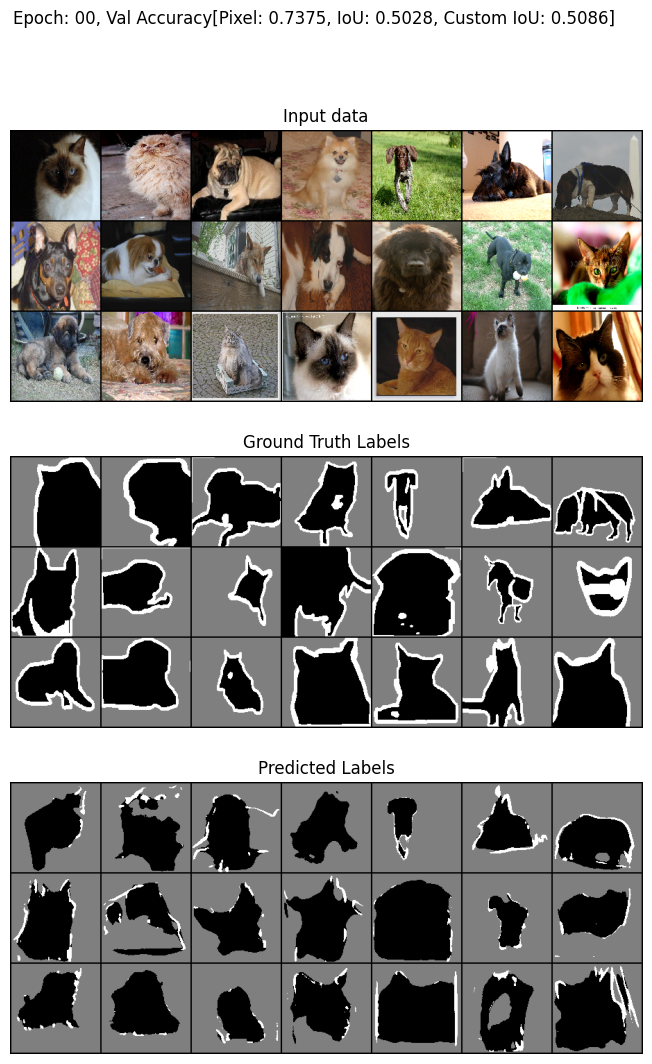

In [ ]:
# Check if our helper functions work as expected and if the image is generated as expected.
save_dir = working_dir / "unet_basic_training_progress_images"
save_dir.mkdir(exist_ok=True)
print_val_dataset_masks(m, val_pets_inputs, val_pets_targets, epoch=0, save_path=None, show_plot=True)

# Model training

In [ ]:
# Train the model for a single epoch
def train_model(model, train_data_loader, optimizer):
    to_device(model.train())
    cel = True
    if cel:
        criterion = nn.CrossEntropyLoss(reduction='mean')
    else:
        criterion = IoULoss(softmax=True)

    running_loss = 0.0
    running_samples = 0

    for batch_idx, (inputs, targets) in tqdm(enumerate(train_data_loader, 0)):
        optimizer.zero_grad()
        inputs = to_device(inputs)
        targets = to_device(targets)
        outputs = model(inputs)

        # The ground truth labels have a channel dimension (NCHW).
        # We need to remove it before passing it into
        # CrossEntropyLoss so that it has shape (NHW) and each element
        # is a value representing the class of the pixel.
        if cel:
            targets = targets.squeeze(dim=1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_samples += targets.size(0)
        running_loss += loss.item()

    print("Trained {} samples, Train Loss: {:.4f}".format(
        running_samples,
        running_loss / (batch_idx+1),
    ))
    return running_loss / (batch_idx+1)

# Define training loop. This will train the model for multiple epochs.
#
# epochs: A tuple containing the start epoch (inclusive) and end epoch (exclusive).
#         The model is trained for [epoch[0] .. epoch[1]) epochs.
#
def train_loop(model, train_data_loader, val_data, epochs: Tuple[int, int], optimizer, scheduler, save_path: str, early_stopping_rounds: int = 3) -> None:
    val_inputs, val_targets = val_data
    epoch_i, epoch_j = epochs
    early_stopping_count = 0
    best_loss = np.inf
    for epoch in range(epoch_i, epoch_j):
        print(f"Epoch: {epoch:02d}, Learning Rate: {optimizer.param_groups[0]['lr']}")
        epoch_train_loss = train_model(model, train_data_loader, optimizer)
        if epoch_train_loss < best_loss:
            best_loss = epoch_train_loss
            early_stopping_count = 0
        else:
            early_stopping_count += 1
        with torch.inference_mode():
            # Display the plt in the final training epoch.
            print_val_dataset_masks(model, val_inputs, val_targets, epoch=epoch, save_path=save_path, show_plot=(epoch == epoch_j-1))

        if scheduler is not None:
            scheduler.step()
        print(f"Best train loss: {best_loss}")
        print(f"Current early stop count: {early_stopping_count}")
        print("")
        if early_stopping_count > early_stopping_rounds:
            print("Earlyyyy stopping! :D")

Epoch: 01, Learning Rate: 0.001


58it [01:13,  1.26s/it]


Trained 3659 samples, Train Loss: 0.7215
Epoch: 01, Val Accuracy[Pixel: 0.7208, IoU: 0.5478, Custom IoU: 0.4700]
Best train loss: 0.7214714884757996
Current early stop count: 0

Epoch: 02, Learning Rate: 0.001


58it [01:10,  1.22s/it]


Trained 3659 samples, Train Loss: 0.5732
Epoch: 02, Val Accuracy[Pixel: 0.6577, IoU: 0.5783, Custom IoU: 0.4345]
Best train loss: 0.5731784947987261
Current early stop count: 0

Epoch: 03, Learning Rate: 0.001


58it [01:10,  1.22s/it]


Trained 3659 samples, Train Loss: 0.5251
Epoch: 03, Val Accuracy[Pixel: 0.7648, IoU: 0.5774, Custom IoU: 0.5104]
Best train loss: 0.5251148733599432
Current early stop count: 0

Epoch: 04, Learning Rate: 0.001


58it [01:09,  1.20s/it]


Trained 3659 samples, Train Loss: 0.4709
Epoch: 04, Val Accuracy[Pixel: 0.8113, IoU: 0.6300, Custom IoU: 0.5829]
Best train loss: 0.47094616910506937
Current early stop count: 0

Epoch: 05, Learning Rate: 0.001


58it [01:09,  1.19s/it]


Trained 3659 samples, Train Loss: 0.4281
Epoch: 05, Val Accuracy[Pixel: 0.8016, IoU: 0.6757, Custom IoU: 0.5845]
Best train loss: 0.428123208469358
Current early stop count: 0

Epoch: 06, Learning Rate: 0.001


58it [01:09,  1.19s/it]


Trained 3659 samples, Train Loss: 0.4034
Epoch: 06, Val Accuracy[Pixel: 0.8187, IoU: 0.6625, Custom IoU: 0.6088]
Best train loss: 0.40335202011568794
Current early stop count: 0

Epoch: 07, Learning Rate: 0.001


58it [01:08,  1.19s/it]


Trained 3659 samples, Train Loss: 0.3726
Epoch: 07, Val Accuracy[Pixel: 0.8280, IoU: 0.6150, Custom IoU: 0.6318]
Best train loss: 0.3725942362999094
Current early stop count: 0

Epoch: 08, Learning Rate: 0.0007


58it [01:09,  1.20s/it]


Trained 3659 samples, Train Loss: 0.3410
Epoch: 08, Val Accuracy[Pixel: 0.8473, IoU: 0.6784, Custom IoU: 0.6665]
Best train loss: 0.34098710890473993
Current early stop count: 0

Epoch: 09, Learning Rate: 0.0007


58it [01:08,  1.19s/it]


Trained 3659 samples, Train Loss: 0.3226
Epoch: 09, Val Accuracy[Pixel: 0.8695, IoU: 0.7100, Custom IoU: 0.6784]


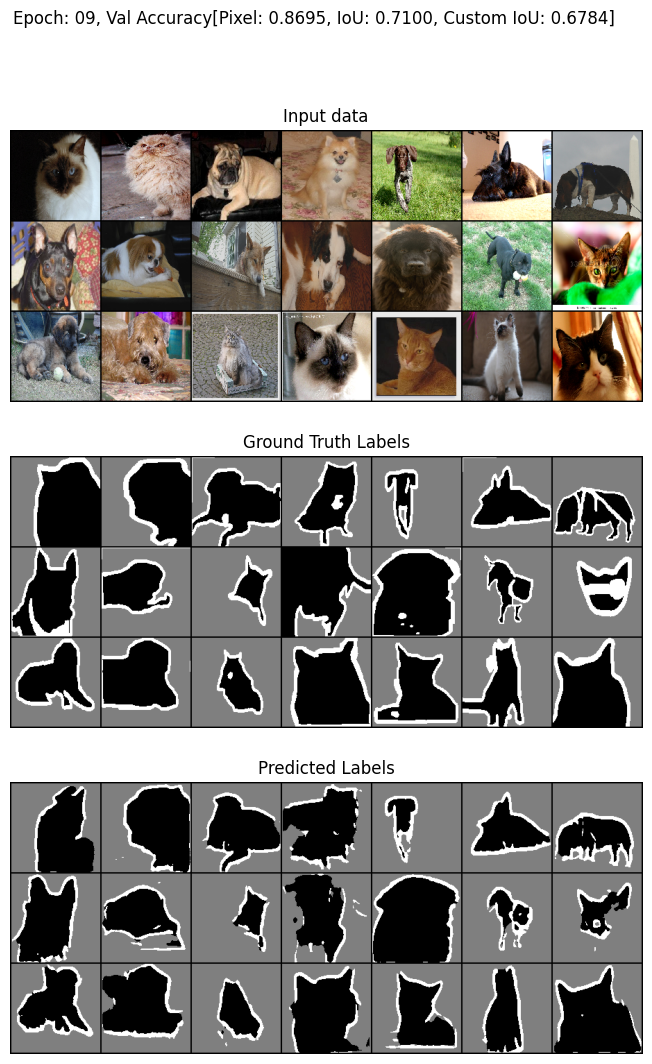

Best train loss: 0.3225596259380209
Current early stop count: 0



In [ ]:
# Train our model for 20 epochs, and record the following:
#
# 1. Training Loss
# 2. Test accuracy metrics for a single batch (21 images) of test images. The following
#    metrics are computed:
#   2.1. Pixel Accuracy
#   2.2. IoU Accuracy (weighted)
#   2.3. Custom IoU Accuracy
#
# We also plot the following for each of the 21 images in the validation batch:
# 1. Input image
# 2. Ground truth segmentation mask
# 3. Predicted segmentation mask
#
# so that we can visually inspect the model's progres and determine how well the model
# is doing qualitatively. Note that the validation metrics on the set of 21 images in
# the validation set is displayed inline in the notebook only for the last training
# epoch.

# Optimizer and Learning Rate Scheduler.
m = UNet(n_channels = 3, n_classes = 3)

to_device(m)

optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)

save_path = working_dir / "unet_basic_training_progress_images"
train_loop(m, pets_train_loader, (val_pets_inputs, val_pets_targets), (1, 10), optimizer, scheduler, save_path)

In [ ]:
# Save the model's checkpoint.
save_model_checkpoint(m, f"models/pets_unet_CrossEntropyLoss_LRSchedule_20_epochs.pth")

# Load both model checkpoints.
load_model_from_checkpoint(m, f"models/pets_unet_CrossEntropyLoss_LRSchedule_20_epochs.pth")

# Model testing

In [ ]:
def test_loop(model, loader):
    to_device(model.eval())
    iou = to_device(TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND))
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(3, average='micro'))

    iou_accuracies = []
    pixel_accuracies = []
    custom_iou_accuracies = []

    print_model_parameters(model)

    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        inputs = to_device(inputs)
        targets = to_device(targets)
        predictions = model(inputs)

        pred_probabilities = nn.Softmax(dim=1)(predictions)
        pred_labels = predictions.argmax(dim=1)

        # Add a value 1 dimension at dim=1
        pred_labels = pred_labels.unsqueeze(1)
        # print("pred_labels.shape: {}".format(pred_labels.shape))
        pred_mask = pred_labels.to(torch.float)

        iou_accuracy = iou(pred_mask, targets)
        # pixel_accuracy = pixel_metric(pred_mask, targets)
        pixel_accuracy = pixel_metric(pred_labels, targets)
        custom_iou = IoUMetric(pred_probabilities, targets)
        iou_accuracies.append(iou_accuracy.item())
        pixel_accuracies.append(pixel_accuracy.item())
        custom_iou_accuracies.append(custom_iou.item())

        del inputs
        del targets
        del predictions

    iou_tensor = torch.FloatTensor(iou_accuracies)
    pixel_tensor = torch.FloatTensor(pixel_accuracies)
    custom_iou_tensor = torch.FloatTensor(custom_iou_accuracies)

    print("Test Dataset Accuracy")
    print(f"Pixel Accuracy: {pixel_tensor.mean():.4f}, IoU Accuracy: {iou_tensor.mean():.4f}, Custom IoU Accuracy: {custom_iou_tensor.mean():.4f}")

In [ ]:
with torch.inference_mode():
    # Accuracy of the model.
    test_loop(m, pets_test_loader)

The Model has 31.04M parameters
Test Dataset Accuracy
Pixel Accuracy: 0.7301, IoU Accuracy: 0.4496, Custom IoU Accuracy: 0.5146


In [ ]:
# zip -r unet_basic_training_progress_images.zip  unet_basic_training_progress_images
# convert -delay 20 -loop 0 *.png myimage.gif

# Segment Anything 2

Ta część zajęć polega na samodzielnym eksperymentowaniu z dokumentacją: https://github.com/facebookresearch/segment-anything

Korzystając z notebooków należy dokonać segmentacji na wybranym przez siebie obrazie oraz jednym filmie korzystając zarówno z opcji automatycznej segmentacji jak i używając punktów na obrazie.

https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/automatic_mask_generator_example.ipynb

https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/image_predictor_example.ipynb

https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/video_predictor_example.ipynb

